## Import libraries

In [1]:
print('go')

go


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


from statsmodels.tsa.seasonal import seasonal_decompose



tfk = tf.keras
tfkl = tf.keras.layers
layers=tfkl
print(tf.__version__)


# ----------------------


# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print('seed:', seed)

2.6.2
seed: 42


## Load Data + EDA

(68528, 7)


 ---------------------------- 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


 ---------------------------- 




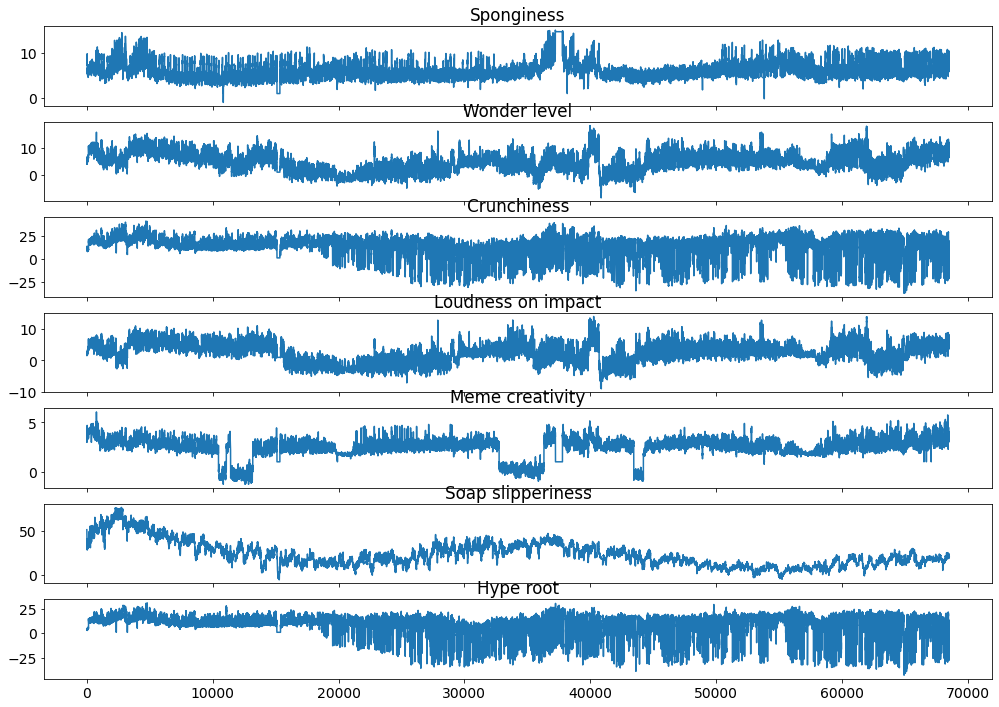

In [3]:
dataset = pd.read_csv('/kaggle/input/timeserie-pasq/Training.csv')
print(dataset.shape)
dataset.head()

print('\n\n ---------------------------- \n\n')

dataset.info()

print('\n\n ---------------------------- \n\n')

def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,12))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

## Sequential Train-Test split

In [4]:
test_ratio = 0.1
test_size = int(dataset.shape[0] * test_ratio)
print(test_size)

X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

6852
(61676, 7) (6852, 7)


## Normalization

In [5]:
# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

## __Parameters__

In [6]:
### TELESCOPE & WINDOW ###

telescope = int(864/8/3)
window = telescope*5
stride = int(telescope)

print('telescope:\t', telescope) 
print('window:\t\t', window)
print('stride:\t\t', stride)

telescope:	 36
window:		 180
stride:		 36


## Build Sequences

In [7]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [8]:
target_labels = X_train_raw.columns

X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, 864)#telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1709, 180, 7), (1709, 36, 7), (166, 180, 7), (166, 864, 7))

## Plots Inspection

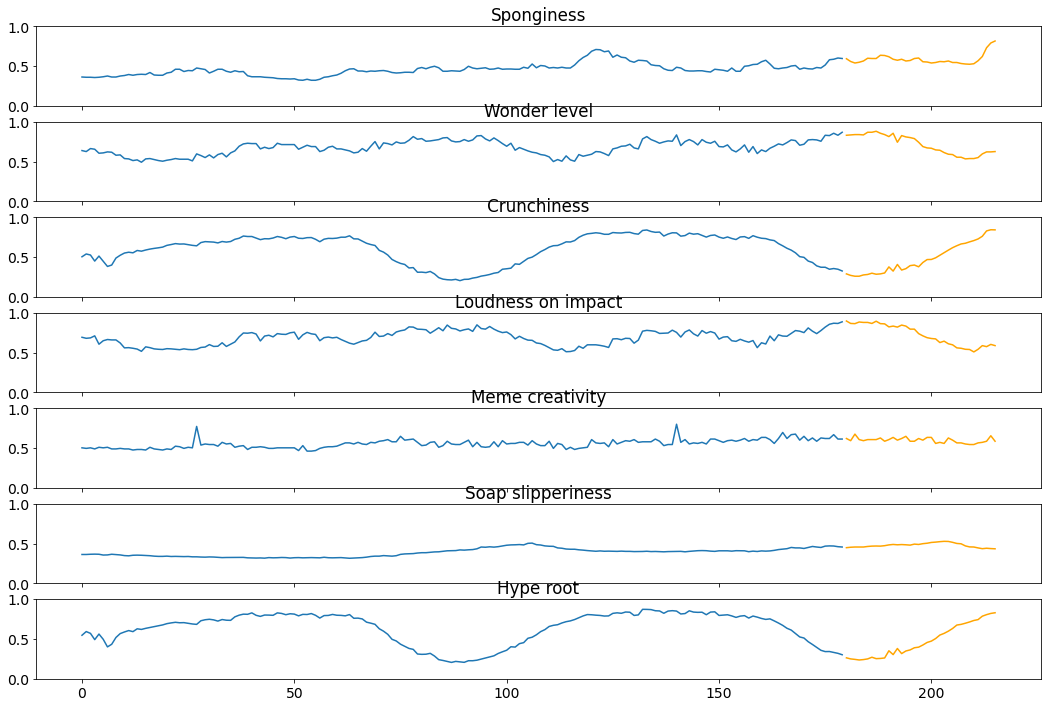

In [9]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(18,12))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
    
inspect_multivariate(X_train, y_train, target_labels, telescope)

## __Model__

In [10]:
from tensorflow.keras import backend as K

class T2V(tfkl.Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original])

In [11]:
input_shape = X_train.shape[1:]
flatten_input = int(input_shape[0]*input_shape[1])
output_shape = y_train.shape[1:]
flatten_output = int(output_shape[0]*output_shape[1])
print('in:', input_shape, flatten_input)
print('out:', output_shape, flatten_output)

units=200
dropout=0.2

num_enc = 4
k_size, num_heads = 32, 8

t2v_dim = 100

ffn_num_hidden, ffn_num_output = int(flatten_input/3), flatten_input+t2v_dim

in: (180, 7) 1260
out: (36, 7) 252


In [12]:
def build_CONV_LSTM_model(input_shape, output_shape):
    ### model definition ###
    inputs = layers.Input(shape=input_shape, name='in')
    
    x = layers.Flatten(name='flat_in')(inputs)
    x = layers.Reshape((1,-1))(x)
    
    ### T2V ###
    time2vec = T2V(output_dim=t2v_dim, name='t2v')
    x = time2vec(x)
    
    
    ### ENCODER ###    
    
    enc_in = x
    
    for i in range(num_enc):
        att_mha = layers.MultiHeadAttention(name='att'+str(i)+'_mha', key_dim=k_size, num_heads=num_heads, dropout=dropout) (enc_in, enc_in, enc_in)
        att_add = layers.Add(name='att'+str(i)+'_add')([att_mha, enc_in])
        att_norm = layers.LayerNormalization(epsilon=1e-6, name='att'+str(i)+'_norm')(att_add)
        ffn_hidden = layers.Conv1D(name='ffn'+str(i)+'_hid', filters=ffn_num_hidden, kernel_size=1, activation='relu')(att_norm)
        ffn_dropout = layers.Dropout(name='ffn'+str(i)+'_hid', rate=dropout)
        ffn_output = layers.Conv1D(name='ffn'+str(i)+'_out', filters=ffn_num_output, kernel_size=1)(ffn_hidden)
        ffn_add = layers.Add(name='ffn'+str(i)+'_add')([att_norm, ffn_output])
        ffn_norm = layers.LayerNormalization(epsilon=1e-6, name='ffn'+str(i)+'_norm')(ffn_add)
        enc_in = ffn_norm
    
    enc_out = ffn_norm
    
    ### DECODER ###

    y=enc_out
    y = layers.Dense(ffn_num_output)(y)
    
    z = tfkl.Dense(flatten_output, activation='elu')(y)
    print(x.shape)
    outputs = tfkl.Reshape((output_shape[-2],output_shape[-1]))(z)
    print(outputs.shape)

    ### model compilation ###
    model = tfk.Model(inputs=[inputs], outputs=outputs)
    model.compile(loss='mse', #tfk.losses.Huber(), 
                  optimizer=tfk.optimizers.Adam(learning_rate=1e-3), 
#                   optimizer = tfk.optimizers.SGD(learning_rate=1e-3, momentum=0.999), #NOPE, WORST
                  metrics=['mse', 'mae', tfk.metrics.RootMeanSquaredError()])

    return model

print('ok')

ok


In [13]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.build(input_shape)
model.summary()
# tfk.utils.plot_model(model, expand_nested=True)

2022-01-15 17:10:05.571306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 17:10:05.678405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 17:10:05.679106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 17:10:05.680696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(None, 1, 1360)
(None, 36, 7)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 [(None, 180, 7)]     0                                            
__________________________________________________________________________________________________
flat_in (Flatten)               (None, 1260)         0           in[0][0]                         
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 1260)      0           flat_in[0][0]                    
__________________________________________________________________________________________________
t2v (T2V)                       (None, 1, 1360)      126102      reshape[0][0]                    
________________________________________________________________

## Train & Save Best

In [14]:
### x MUST BE x AND y CONCATENATED
tf.config.run_functions_eagerly(True)

batch_size = 32 #32
epochs = 250

es_patience = 35
lr_patience = 15

# Train the model
history = model.fit(
    x = [X_train],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=es_patience, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=lr_patience, verbose=1, factor=0.3, min_lr=1e-6)
    ]
).history

2022-01-15 17:10:08.610060: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250
43/43 [==============================] - 5s 96ms/step - loss: 0.9923 - mse: 0.9923 - mae: 0.7773 - root_mean_squared_error: 0.9962 - val_loss: 0.4685 - val_mse: 0.4685 - val_mae: 0.4535 - val_root_mean_squared_error: 0.6844
Epoch 2/250
43/43 [==============================] - 4s 89ms/step - loss: 0.1876 - mse: 0.1876 - mae: 0.2822 - root_mean_squared_error: 0.4331 - val_loss: 0.0463 - val_mse: 0.0463 - val_mae: 0.1725 - val_root_mean_squared_error: 0.2153
Epoch 3/250
43/43 [==============================] - 4s 99ms/step - loss: 0.0305 - mse: 0.0305 - mae: 0.1353 - root_mean_squared_error: 0.1747 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1333 - val_root_mean_squared_error: 0.1762
Epoch 4/250
43/43 [==============================] - 4s 99ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1205 - root_mean_squared_error: 0.1563 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1457 - val_root_mean_squared_error: 0.1794
Epoch 5/250
43/43 [==============================] - 4s 

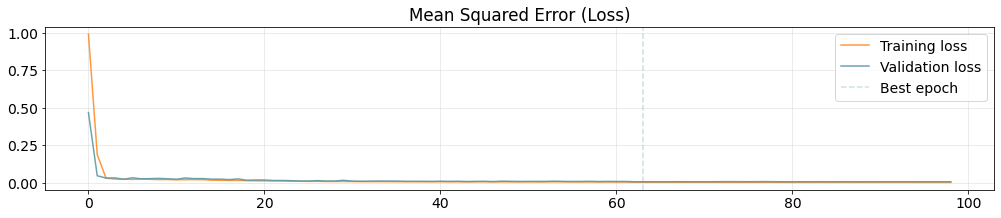

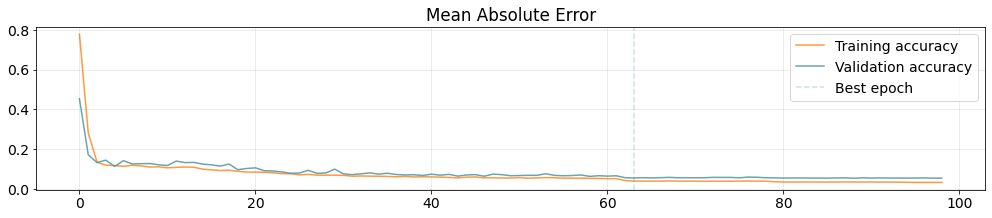

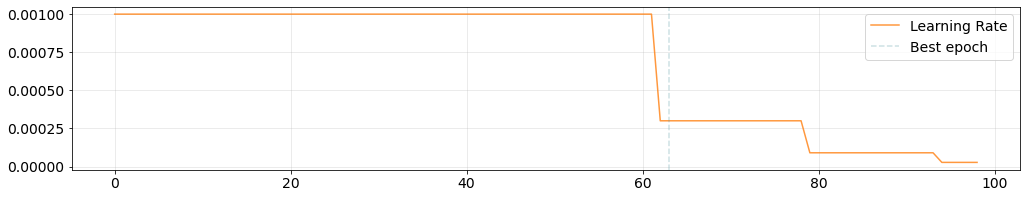

In [15]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,3))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [16]:
model_dir = '/kaggle/working/models'
model.save(os.path.join(model_dir, 'model'))
print('saved')

2022-01-15 17:17:36.789881: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


saved


## Test evaluation

In [17]:
### load ###
%cd /kaggle/working/models
model = tfk.models.load_model('model')
print('loaded')

/kaggle/working/models
loaded


In [18]:
a=np.zeros((3,2))
a1 = a[:,0]
print(a1)

[0. 0. 0.]


In [19]:
### Predict the test set ### 
print(X_test.shape)
predictions = model.predict(X_test)
print(predictions.shape)


i=0
while predictions.shape[1] != 864:
    X_test1 = tf.concat((X_test, predictions), axis=1)
    X_test1 = X_test1[:,-window:,:]
    pred1 = model.predict(X_test1)
    predictions = np.concatenate((predictions, pred1), axis=1)
    i+=1
print('concatenations=', i)
    
    
# X_min = X_train_raw.min()
# X_max = X_train_raw.max()
# X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
# X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

# pred_val = predictions[:,:,:]
# predictions = (predictions+X_min) * (X_max-X_min)
# y_test = (y_test+X_min) * (X_max-X_min)
    
print(y_test.flatten().shape, predictions.flatten().shape)
    
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
print('mse:', mean_squared_error)
print('mae:', mean_absolute_error)

(166, 180, 7)
(166, 36, 7)
concatenations= 23
(1003968,) (1003968,)
mse: tf.Tensor(0.01187739, shape=(), dtype=float32)
mae: tf.Tensor(0.07975507, shape=(), dtype=float32)




---------------- 0 ----------------




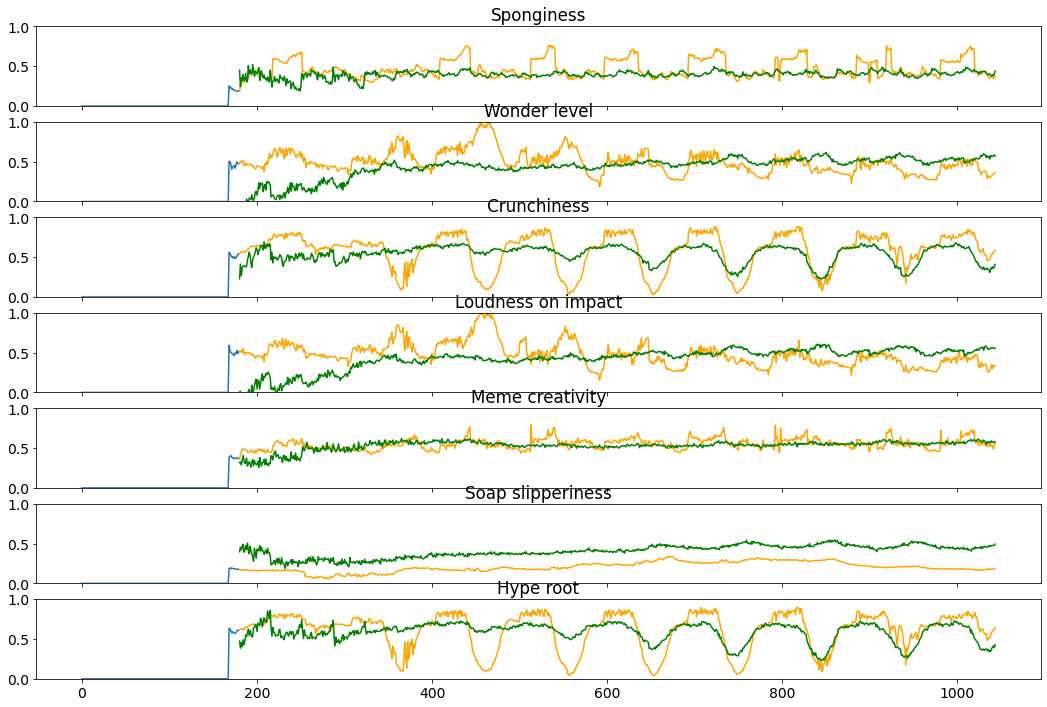



---------------- 1 ----------------




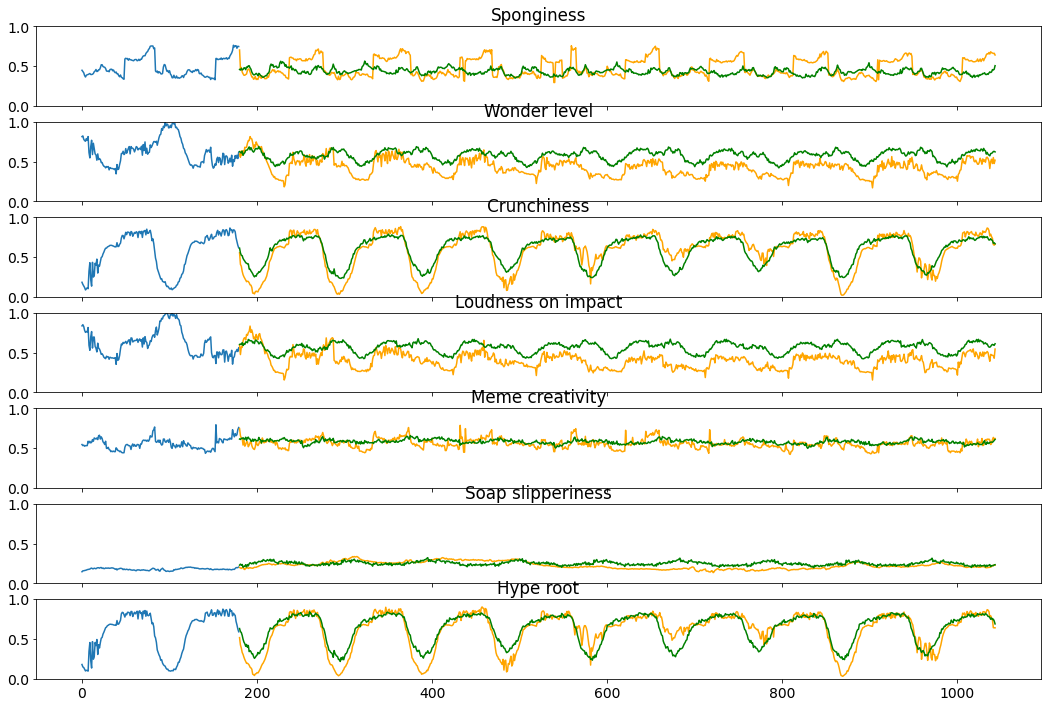



---------------- 2 ----------------




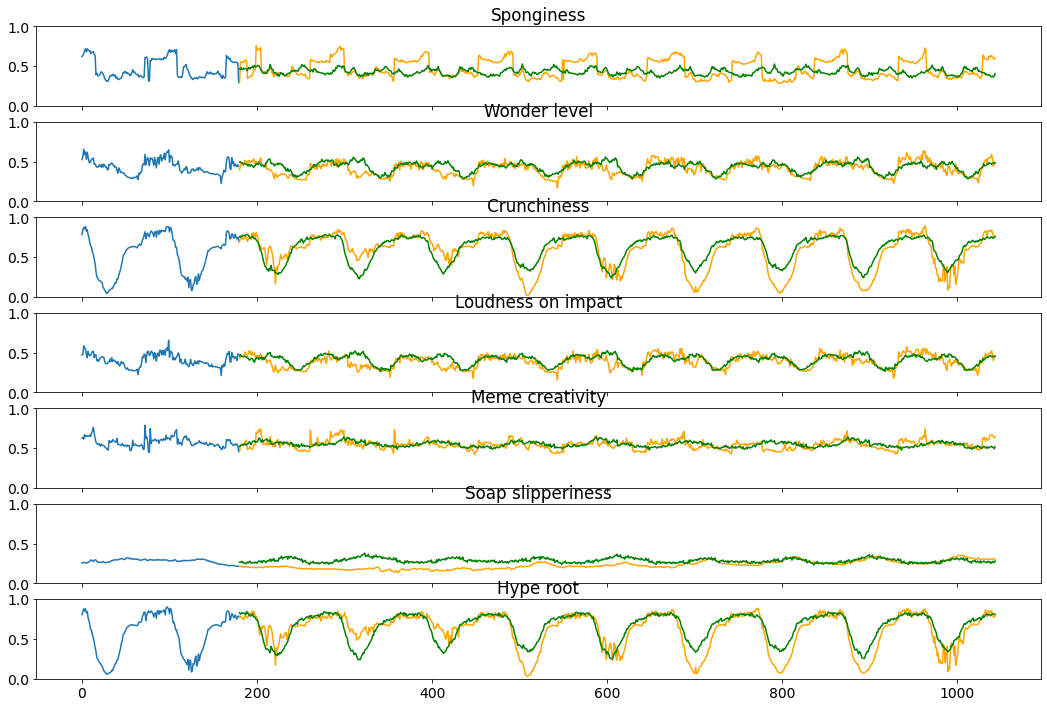



---------------- 3 ----------------




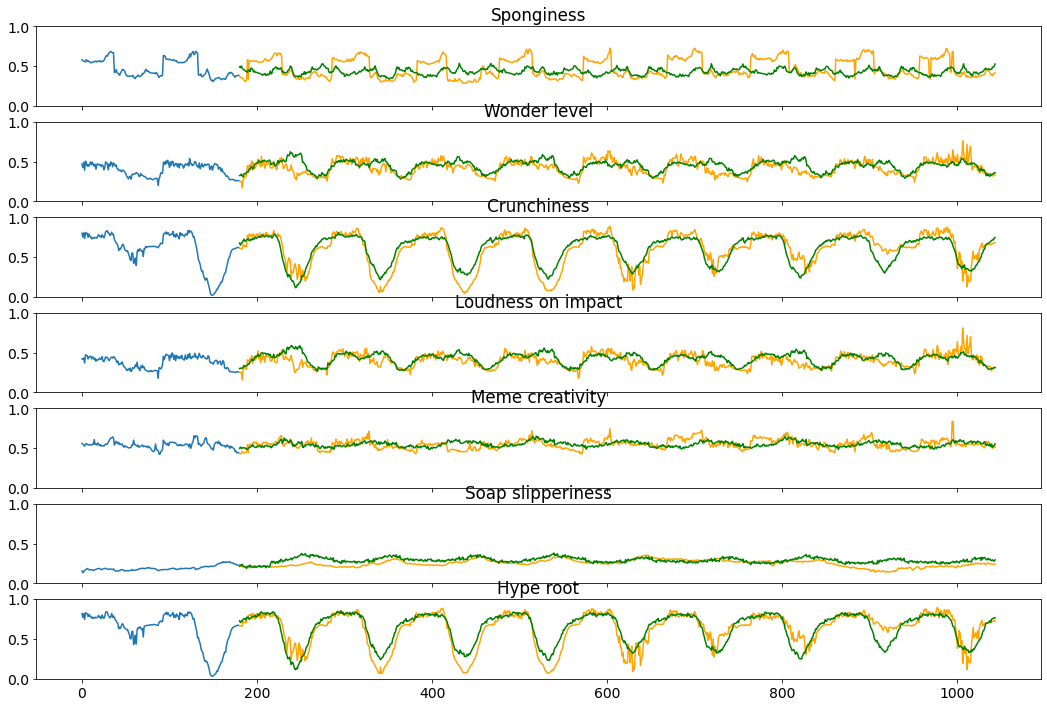



---------------- 4 ----------------




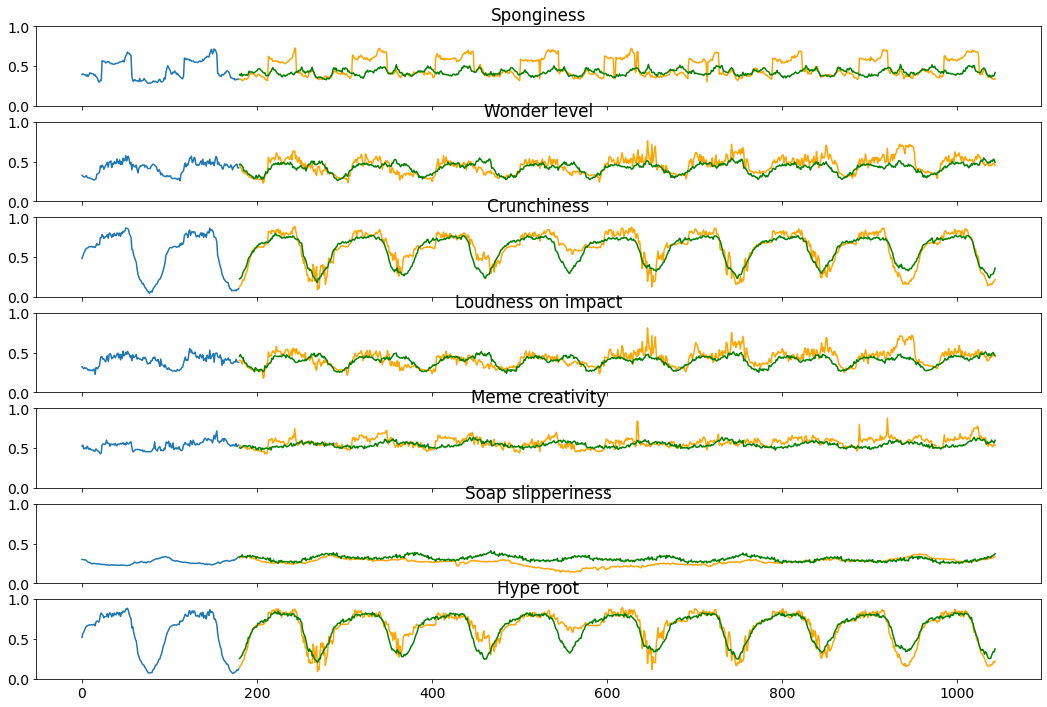



---------------- 5 ----------------




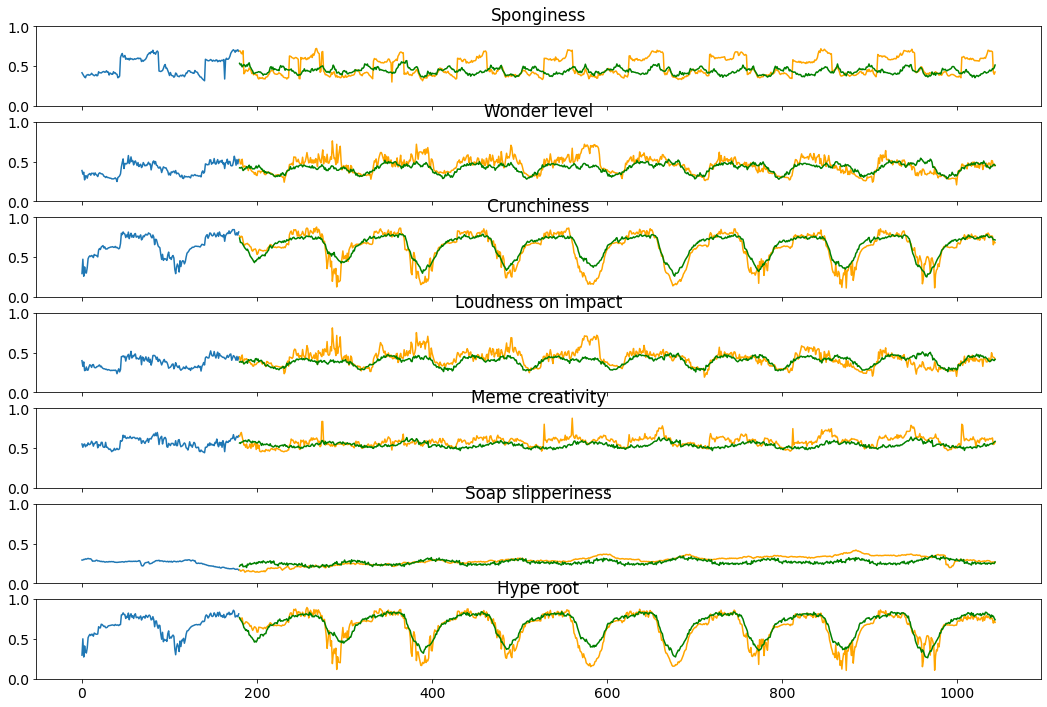



---------------- 6 ----------------




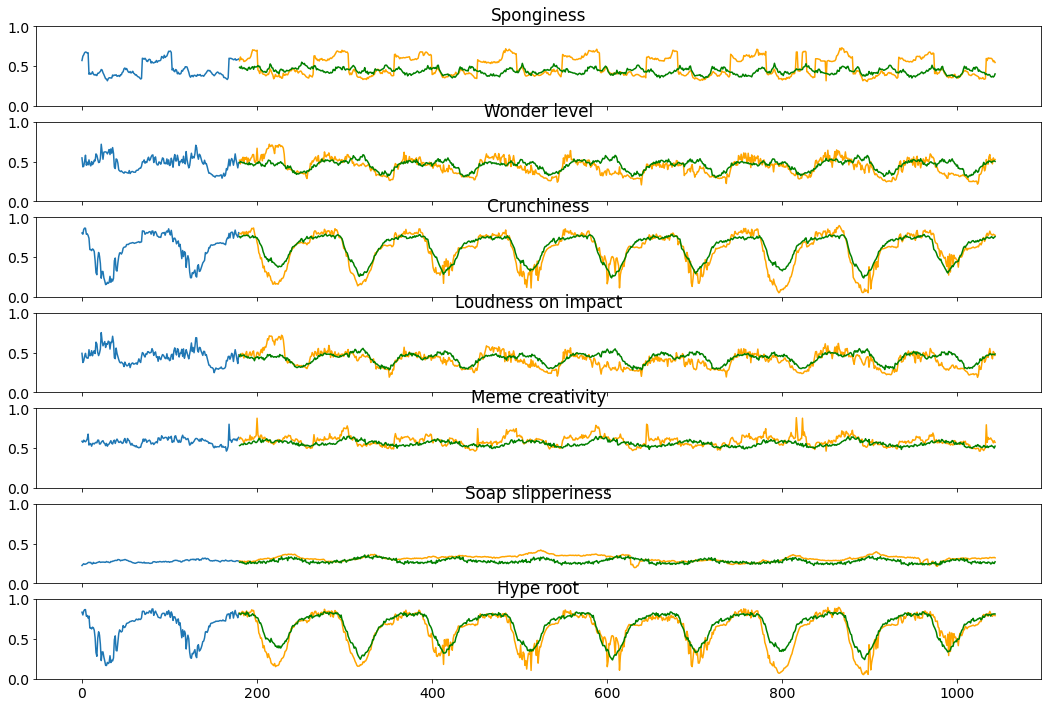



---------------- 7 ----------------




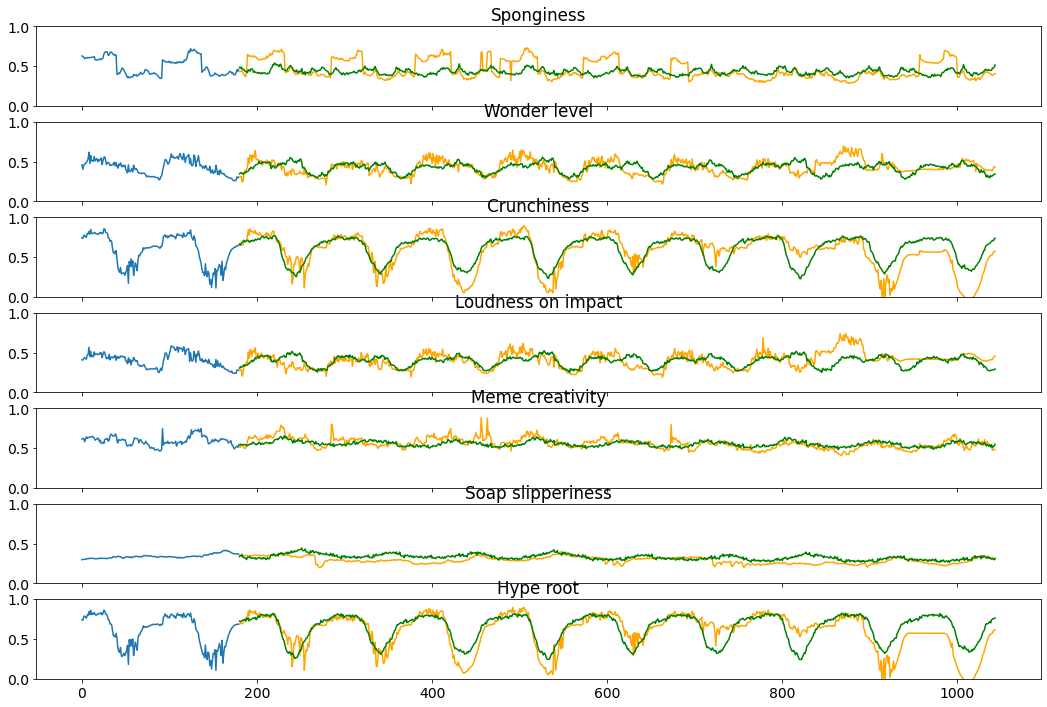



---------------- 8 ----------------




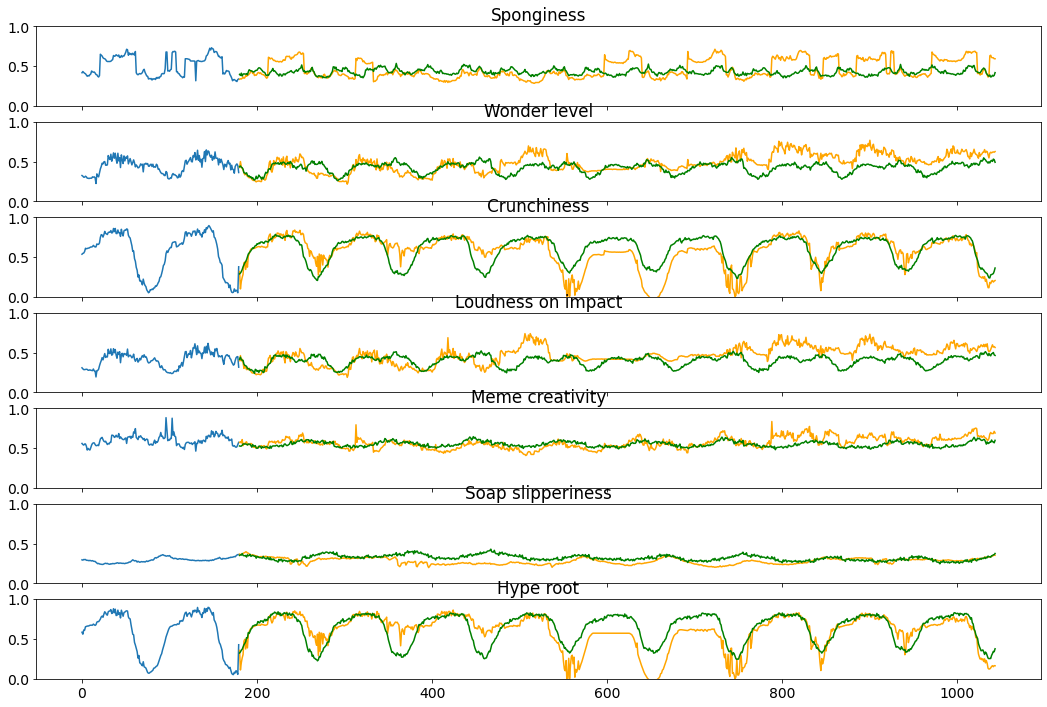



---------------- 9 ----------------




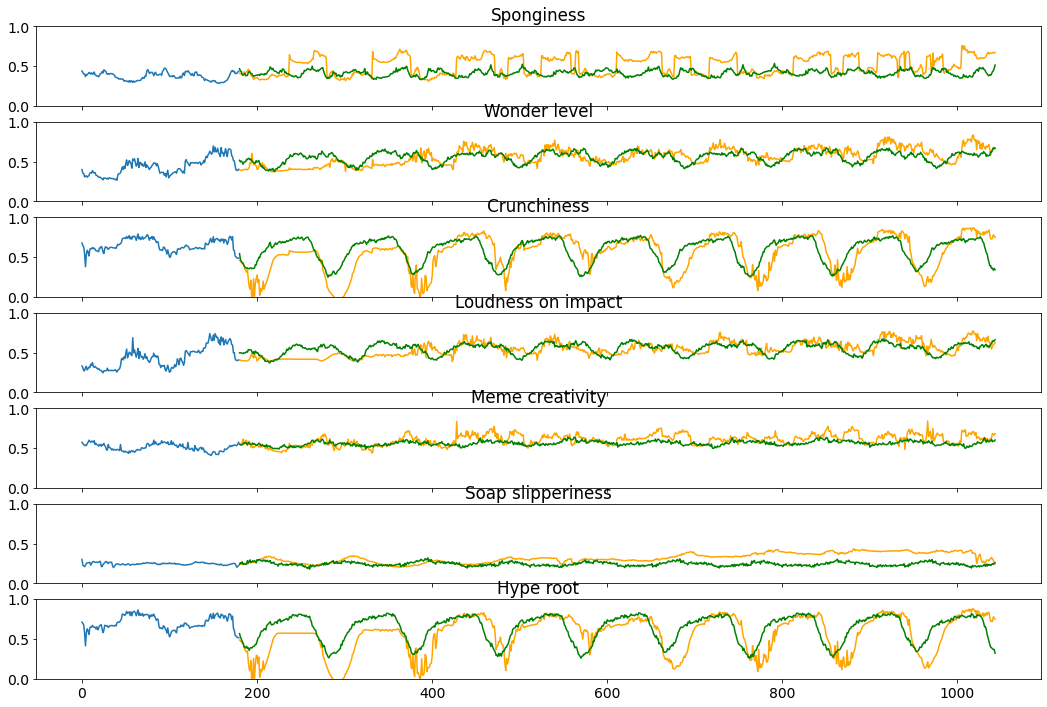

In [20]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(18,12))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
for i in range(10):
    print('\n\n----------------', i, '----------------\n\n')
    inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, 864, idx=i*10)#telescope)


### zippalo prima

In [21]:
%cd /kaggle/working/models
!ls model

!ls
!zip -r modela.zip model

%mv modela.zip /kaggle/working

/kaggle/working/models
assets	keras_metadata.pb  saved_model.pb  variables
model
  adding: model/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 94%)
  adding: model/assets/ (stored 0%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 79%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 23%)


## Predict the future 

In [22]:
# future = dataset[-window:]     #take last window to predict future telescope
# future = (future-X_min)/(X_max-X_min)      #normalize
# future = np.expand_dims(future, axis=0)
# future.shape

In [23]:
# maes = []
# for i in range(predictions.shape[1]):
#     ft_maes = []
#     for j in range(predictions.shape[2]):
#         ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
#     ft_maes = np.array(ft_maes)
#     maes.append(ft_maes)
# maes = np.array(maes)

In [24]:
# future_predictions = model.predict(future)

### Predicted Plots w/ std-dev

In [25]:
# figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
# for i, col in enumerate(target_labels):
#     axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
#     axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
#     axs[i].fill_between(
#         np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
#         future_predictions[0,:,i]+maes[:,i], 
#         future_predictions[0,:,i]-maes[:,i], 
#         color='orange', alpha=.3)
#     axs[i].set_title(col)
#     # axs[i].set_ylim(0,1)
# plt.show()

## zippalo sul server